# Определение токсичных комментариев

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Нужно построить модель со значением метрики качества *F1* не меньше 0.75. 

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from lightgbm import LGBMClassifier

## 1 Подготовка

In [2]:
# знакомство с данными
df = pd.read_csv('***.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Данные содержат текст и целевой признак. Можно приступать к подготовке данных. Пропусков нет.

Создадим фнукцию для лемматизации

In [3]:
# функция делает список из слов, лемматизирует, возвращает строку с нижнем регистром,
# удаляет все лишние символы, оставляя только пробелы между словами
def lemmatizer(string):
    stemmer = WordNetLemmatizer() # NLTK лемматизация
    word_list = nltk.word_tokenize(string)
    text = ' '.join([stemmer.lemmatize(w) for w in word_list]).lower()
    text = ' '.join(re.sub(r'[^a-z]', ' ', text).split())
    return text

In [4]:
df['lemm_text'] = df['text'].apply(lemmatizer) # лемматизируем 

Проверка лемматизированного текста:

In [5]:
df['text'].head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: text, dtype: object

In [6]:
df['lemm_text'].head()

0    explanation why the edits made under my userna...
1    d aww he match this background colour i m seem...
2    hey man i m really not trying to edit war it s...
3    more i ca n t make any real suggestion on impr...
4    you sir are my hero any chance you remember wh...
Name: lemm_text, dtype: object

**Разделение на выборки:**

In [7]:
features = df['lemm_text']
target = df['toxic']

In [8]:
target.value_counts(normalize=True) # смотрим баланс классов

0    0.898321
1    0.101679
Name: toxic, dtype: float64

90% отрицательного класса и 10% положительного. Наблюдается большой дисбаланс классов, необходимо это будет учесть в построении модели.

In [9]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, train_size=0.6, random_state=42) # отделение 60% данных для обучающей выборки

In [10]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=42) 
# разделение оставшихся данных на тестовую и валидационную выборки

Проверим разделение выборок:

In [11]:
print('Обучающая выборка:',round(features_train.shape[0]/features.shape[0]*100,1),'%')
print('Валидационная выборка:',round(features_valid.shape[0]/features.shape[0]*100,1),'%')
print('Тестовая выборка:',round(features_test.shape[0]/features.shape[0]*100,1),'%')

Обучающая выборка: 60.0 %
Валидационная выборка: 20.0 %
Тестовая выборка: 20.0 %


Загрузим стоп слова. Векторизируем счетчик слов.

In [12]:
nltk.download('stopwords')
stop_words = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

[nltk_data] Downloading package stopwords to C:\Users\***
[nltk_data]     **\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
corpus_train = features_train.values
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_train.shape

(95742, 122387)

In [14]:
corpus_valid = features_valid.values
tf_idf_valid = count_tf_idf.transform(corpus_valid)
tf_idf_valid.shape

(31914, 122387)

In [15]:
corpus_test = features_test.values
tf_idf_test = count_tf_idf.transform(corpus_test)
tf_idf_test.shape

(31915, 122387)

Текст лемматизирован, счетчик слов переведен в вектор, стоп слова загружены. Данные готовы для обучения.

## 2 Обучение

Используем 2 наиболее быстрые модели для обучения, задача, получить метрику качества не менее 0,75.

Начнем с логистической регрессии с параметром class_weight='balanced'

In [16]:
%%time
best_model = None
best_result = 0
for reg in np.arange(0.9,5.0,0.2):
    model_lr = LogisticRegression(class_weight='balanced', max_iter=1000, C=reg, random_state=42)
    model_lr.fit(tf_idf_train, target_train)
    prediction = model_lr.predict(tf_idf_valid)
    result = f1_score(target_valid, prediction)
    if result > best_result:
            best_model_lr = model_lr
            best_result = result
print('F1-мера лучшей модели логистической регрессии на валидационной выборке:', best_result)
print('Лучшие гиперпараметры:', best_model_lr)

F1-мера лучшей модели логистической регрессии на валидационной выборке: 0.7619047619047619
Лучшие гиперпараметры: LogisticRegression(C=4.300000000000002, class_weight='balanced', max_iter=1000,
                   random_state=42)
Wall time: 1min 10s


Модель логистической регрессии показала хороший результат.

Используем модель LGBMClassifier с параметром class_weight='balanced' и подберем гиперпараметры.

In [17]:
%%time
best_model = None
best_result = 0
for est in np.arange(270,291,10):
    for leaves in np.arange(250,271,10):
        model_lgbm = LGBMClassifier(random_state=42, n_estimators=est, num_leaves=leaves, class_weight='balanced')
        model_lgbm.fit(tf_idf_train, target_train) 
        predictions_valid = model_lgbm.predict(tf_idf_valid) 
        result = f1_score(target_valid, predictions_valid) 
        if result > best_result:
            best_model_lgbm = model_lgbm
            best_result = result
print('F1-мера лучшей модели LGBM на валидационной выборке:', best_result)
print('Лучшие гиперпараметры:', best_model_lgbm)

F1-мера лучшей модели LGBM на валидационной выборке: 0.7723760463618803
Лучшие гиперпараметры: LGBMClassifier(class_weight='balanced', n_estimators=290, num_leaves=250,
               random_state=42)
Wall time: 25min 6s


Модель LGBM показала лучше результат. Проведем тестирование на тестовой выборке.

In [18]:
prediction = best_model_lr.predict(tf_idf_test)
print('F1-мера логистической регрессии на тестовой выборке:', f1_score(prediction, target_test)) 

F1-мера логистической регрессии на тестовой выборке: 0.7570810659969304


In [19]:
prediction = best_model_lgbm.predict(tf_idf_test)
print('F1-мера LGBM на тестовой выборке:', f1_score(prediction, target_test)) 

F1-мера LGBM на тестовой выборке: 0.7646685696162385


Обе модели справились с поставленной задачей. Но выбор модели мы делаем по лучшему результату на валидационной выборке.

Дополнительно найдем roc_auc_score и построим ROC-кривую.

0.9559667924236257

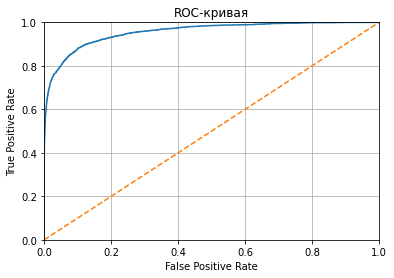

In [20]:
probabilities_test = best_model_lgbm.predict_proba(tf_idf_test)
probabilities_one_test = probabilities_test[:, 1]
    
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
    
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.grid()
    
roc_auc_score(target_test, probabilities_one_test)

## 3 Выводы

- Были выбраны 2 быстрые модели для обучения.
- Логистическая регрессия показала хороший результат f1 = 0.76.
- LightGBMClassifier показала себя лучше на валидационной выборке f1 = 0.77.
- Была достигнута F1 = 0.76 на тестовой выборке, с помощью модели LightGBM
- ROC-AUC на тестовой выборке 0,96